In [1]:
import pydot
from IPython.display import SVG, display
from pydrake.all import (DiagramBuilder, 
                        MeshcatVisualizer, 
                        Simulator, 
                        StartMeshcat)
from manipulation.scenarios import MakeManipulationStation 

In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [3]:
model_directives = '''
directives: 
- add_model: 
    name: iiwa0
    file: package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [-1.57]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa0::iiwa_link_0
    
- add_model: 
    name: wsg0
    file: package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_with_tip.sdf
- add_weld: 
    parent: iiwa0::iiwa_link_7
    child: wsg0::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy {deg: [90, 0, 90]}

- add_model:
    name: iiwa1
    file: package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [-1.57]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [ 1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa1::iiwa_link_0
    X_PC:
        translation: [.6, 0, 0]
        rotation: !Rpy { deg: [0, 0, 0]}
- add_model:
    name: wsg1
    file: package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_with_tip.sdf
- add_weld:
    parent: iiwa1::iiwa_link_7
    child: wsg1::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy { deg: [90, 0, 90]}

'''


In [5]:
builder = DiagramBuilder()
station = builder.AddSystem(
    MakeManipulationStation(model_directives)
)
plant = station.GetSubsystemByName('plant')
controller_plant = station.GetSubsystemByName(
    'iiwa0_controller').get_multibody_plant_for_control()

visualizer = MeshcatVisualizer.AddToBuilder(
    builder, station.GetOutputPort('query_object'), meshcat
)

diagram = builder.Build()

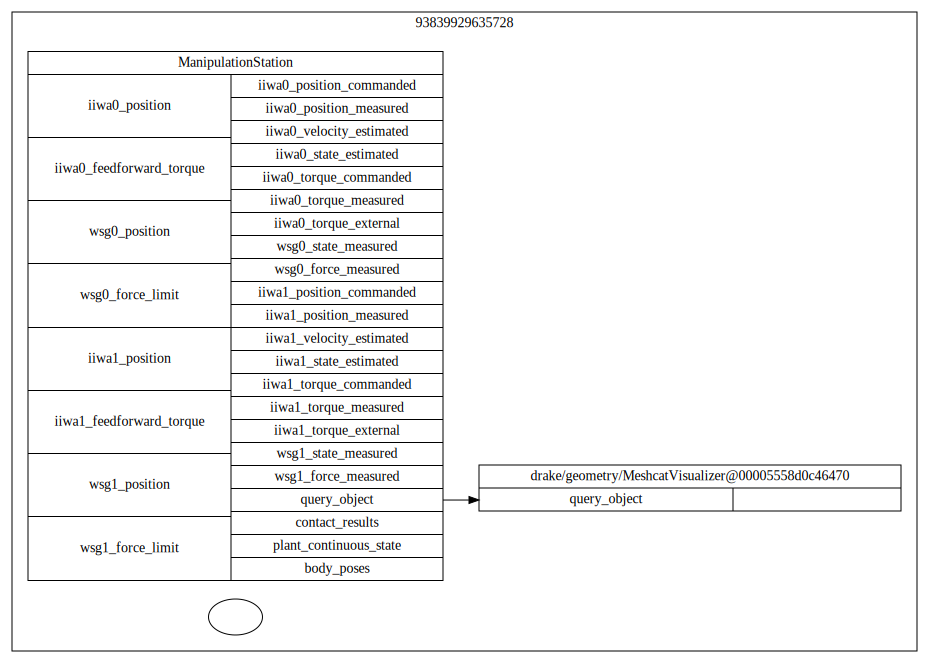

In [6]:
display(SVG(
    pydot.graph_from_dot_data(
        diagram.GetGraphvizString(max_depth=1)
    )[0].create_svg()
))

In [7]:
simulator = Simulator(diagram)
context = simulator.get_mutable_context()
station_context = station.GetMyMutableContextFromRoot(context)
plant_context = plant.GetMyMutableContextFromRoot(context)

In [10]:
q0 = plant.GetPositions(plant_context, plant.GetModelInstanceByName('iiwa0'))

station.GetInputPort('iiwa0_position').FixValue(station_context, q0)
station.GetInputPort('iiwa1_position').FixValue(station_context, q0)

station.GetInputPort('wsg0_position').FixValue(station_context, [0])
station.GetInputPort('wsg1_position').FixValue(station_context, [0])


In [11]:
simulator.AdvanceTo(0.1)